In [30]:
# Calulcate gradient_ns and gradient_we based on NLDAS topography netcdf.
# NLDAS topography netcdf is from https://ldas.gsfc.nasa.gov/nldas/elevation.

import os
import numpy as np
import xarray as xr
import netCDF4 as nc
import gdal, ogr, osr
import rasterio,subprocess
import matplotlib.pyplot as plt

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    #reference:https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html
    
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)    
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326) # 4326 is WGS84. 
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

def main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster

#====================================================================================
# Main script
root_dir = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet/data/nldas_topo'
nldas_elev_file = 'NLDAS_elevation.nc4' # download from https://ldas.gsfc.nasa.gov/nldas/elevation
nldas_force_file = '/glade/u/home/hongli/scratch/2020_04_21nldas_gmet/data/nldas_daily_utc/NLDAS_2016.nc'
gridinfo_tpl = 'conus_ens_grid_eighth_deg_v1p1.nc'

ofile = 'NLDAS_topo.nc'
if os.path.exists(os.path.join(root_dir,ofile)):
    os.remove(os.path.join(root_dir,ofile))
subfolder = 'raster'
if not os.path.exists(os.path.join(root_dir,subfolder)):
    os.makedirs(os.path.join(root_dir,subfolder))

# #====================================================================================
# # read NLDAS topography
# f = xr.open_dataset(os.path.join(root_dir,nldas_elev_file))
# lat = f['lat'].values[:] #(224)
# lon = f['lon'].values[:] #(464)
# NLDAS_elev = f['NLDAS_elev'].values[:] #(1,224,464)
# NLDAS_slope = f['NLDAS_slope'].values[:] 
# NLDAS_aspect = f['NLDAS_aspect'].values[:] 

# #====================================================================================
# # read NLDAS forcing
# f = xr.open_dataset(os.path.join(root_dir,nldas_force_file))
# lat_110 = f['lat_110'].values[:] #(224)
# lon_110 = f['lon_110'].values[:] #(464)
# tair_avg = f['tair_avg'].values[:] #(365,224,464)

# #====================================================================================
# # read AndyN topo
# f_grid = xr.open_dataset(os.path.join(root_dir,gridinfo_tpl))
# latitude = f_grid['latitude'].values[:] #(y,x) = (224,464)
# longitude = f_grid['longitude'].values[:] 
# grid_elev = f_grid['elev'].values[:]

# #====================================================================================
# # save STN dem to raster and calculate its slope and aspect 
# # save nldas DEM raster
# rasterOrigin = (np.nanmin(lon),np.nanmin(lat))
# pixelWidth = lon[1]-lon[0]
# pixelHeight = lat[1]-lat[0]
# dem_raster = os.path.join(root_dir,subfolder,'NLDAS_elev.tif')
# array = NLDAS_elev[0,:,:]
# array2raster(dem_raster,rasterOrigin,pixelWidth,pixelHeight,array)

# # save AndyN DEM raster
# rasterOrigin = (np.nanmin(longitude),np.nanmin(latitude))
# pixelWidth = latitude[1,0]-latitude[0,0]
# pixelHeight = longitude[0,1]-longitude[0,0]
# dem_raster = os.path.join(root_dir,subfolder,'STN_elev.tif')
# array = grid_elev
# array2raster(dem_raster,rasterOrigin,pixelWidth,pixelHeight,array)

# # # Then, do ArcGIS processes:
# # # (1) project dem raster (WGS84 -> UAS Contiguous albers Equal Area Conic, degree -> meter)
# # # (2) calculate slope and aspect
# # # (3) project slope and aspect raster (-> WGS84. Use DEM raster as reference for output cellsize.)
# # # (4) extract by mask for slope and aspect raster (to have the same # grids as raw DEM)
# # # (5) export slope and aspect raster (nodata as -9999)

#====================================================================================
# read dem, slope and aspect from STN (AndyN)
dem_raster = os.path.join(root_dir,subfolder,'STN_elev.tif')
slope_raster = os.path.join(root_dir,subfolder,'STN_slope.tif')
aspect_raster = os.path.join(root_dir,subfolder,'STN_aspect.tif')

with rasterio.open(dem_raster) as dataset:
        STN_elev=dataset.read(1)
with rasterio.open(slope_raster) as dataset:
        STN_slope=dataset.read(1)
with rasterio.open(aspect_raster) as dataset:
        STN_aspect=dataset.read(1)

# calculate gradient
STN_slope = np.where(STN_slope==-9999, np.nan,STN_slope)
STN_aspect = np.where(STN_aspect==-9999, np.nan,STN_aspect)

#====================================================================================
# FILL
# 1. use AndyN topo and zero to fill NLDAS elevation
mask_fill = ((np.isnan(NLDAS_elev[0,:,:])) & (~np.isnan(tair_avg[0,:,:])) & (~np.isnan(STN_elev)))
mask_cannot_fill =  ((np.isnan(NLDAS_elev[0,:,:])) & (~np.isnan(tair_avg[0,:,:])) & (np.isnan(STN_elev)))

NLDAS_elev_new = np.empty_like(NLDAS_elev)
NLDAS_elev_new[:] = NLDAS_elev[:]
NLDAS_elev_new[:,mask_fill] = STN_elev[mask_fill]
NLDAS_elev_new[:,mask_cannot_fill] = 0.0

# 2. use AndyN topo and zero to fill NLDAS slope
mask_fill = ((np.isnan(NLDAS_slope[0,:,:])) & (~np.isnan(tair_avg[0,:,:])) & (~np.isnan(STN_slope)))
mask_cannot_fill =  ((np.isnan(NLDAS_slope[0,:,:])) & (~np.isnan(tair_avg[0,:,:])) & (np.isnan(STN_slope)))

NLDAS_slope_new = np.empty_like(NLDAS_slope)
NLDAS_slope_new[:] = NLDAS_slope[:]
NLDAS_slope_new[:,mask_fill] = STN_slope[mask_fill]
NLDAS_slope_new[:,mask_cannot_fill] = 0.0

# 3. use AndyN topo and zero to fill NLDAS aspect
mask_fill = ((np.isnan(NLDAS_aspect[0,:,:])) & (~np.isnan(tair_avg[0,:,:])) & (~np.isnan(STN_aspect)))
mask_cannot_fill =  ((np.isnan(NLDAS_aspect[0,:,:])) & (~np.isnan(tair_avg[0,:,:])) & (np.isnan(STN_aspect)))

NLDAS_aspect_new = np.empty_like(NLDAS_aspect)
NLDAS_aspect_new[:] = NLDAS_aspect[:]
NLDAS_aspect_new[:,mask_fill] = STN_aspect[mask_fill]
NLDAS_aspect_new[:,mask_cannot_fill] = 0.0

#====================================================================================
# calculate gradient
gradient_n_s = np.multiply(NLDAS_slope_new,np.cos(np.radians(NLDAS_aspect_new)))
gradient_w_e = np.multiply(NLDAS_slope_new,np.sin(np.radians(NLDAS_aspect_new)))

##====================================================================================
# save
with nc.Dataset(os.path.join(root_dir,nldas_elev_file)) as src:
    with nc.Dataset(os.path.join(root_dir,ofile), "w") as dst:

        # copy dimensions
        for name, dimension in src.dimensions.items():
             dst.createDimension(
                name, (len(dimension) if not dimension.isunlimited() else None))

        include = ['lat', 'lon', 'time', 'NLDAS_elev']
        for name, variable in src.variables.items():
            if name in include:
                x = dst.createVariable(name, variable.datatype, variable.dimensions)               
                dst[name].setncatts(src[name].__dict__)
                dst[name][:]=src[name][:] 
                
        vars_short = ['gradient_n_s','gradient_w_e']
        vars_standard_name = ['N_S_Slope','W_E_Slope']
        vars_long_name = ['Smoothed Topographic Gradient (Slope) from North to South',
                          'Smoothed Topographic Gradient (Slope) from West to East']

        for i, var in enumerate(vars_short):
            var_i = dst.createVariable(var,src['NLDAS_slope'].datatype,src['NLDAS_slope'].dimensions) # note: unlimited dimension is leftmost
            dst[var].setncatts(src['NLDAS_slope'].__dict__) # firstly copy all attributes
            var_i.standard_name = vars_standard_name[i] # modify some attributes
            var_i.long_name = vars_long_name[i]
            dst[var][:]=src['NLDAS_slope'][:] 
        
        dst.variables['NLDAS_elev'][:] = NLDAS_elev_new
        
        dst.variables['gradient_n_s'][:] = gradient_n_s
        dst.variables['gradient_w_e'][:] = gradient_w_e
        
        dst.variables['gradient_n_s'].vmin = np.nanmin(gradient_n_s)
        dst.variables['gradient_n_s'].vmax = np.nanmax(gradient_n_s)
        
        dst.variables['gradient_w_e'].vmin = np.nanmin(gradient_w_e)
        dst.variables['gradient_w_e'].vmax = np.nanmax(gradient_w_e)        
        
print('Done')

Done


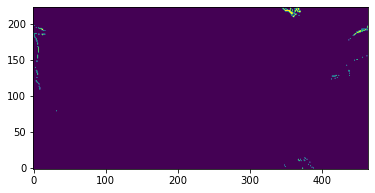

In [15]:
plt.imshow((mask_fill1!=mask_fill2),origin='lower')
plt.show()

# plt.imshow(mask_cannot_fill,origin='lower')
# plt.show()

In [26]:
# 1. use AndyN topo and zero to fill NLDAS elevation
mask_fill = ((np.isnan(NLDAS_elev[0,:,:])) & (~np.isnan(tair_avg[0,:,:])) & (~np.isnan(STN_elev)))
mask_cannot_fill =  ((np.isnan(NLDAS_elev[0,:,:])) & (~np.isnan(tair_avg[0,:,:])) & (np.isnan(STN_elev)))

NLDAS_elev_new = np.empty_like(NLDAS_elev)
NLDAS_elev_new[:] = NLDAS_elev[:]
NLDAS_elev_new[:,mask_fill] = STN_elev[mask_fill]
NLDAS_elev_new[:,mask_cannot_fill] = 0.0

# 2. use AndyN topo and zero to fill NLDAS slope
mask_fill = ((np.isnan(NLDAS_slope[0,:,:])) & (~np.isnan(tair_avg[0,:,:])) & (~np.isnan(STN_slope)))
mask_cannot_fill =  ((np.isnan(NLDAS_slope[0,:,:])) & (~np.isnan(tair_avg[0,:,:])) & (np.isnan(STN_slope)))

NLDAS_slope_new = np.empty_like(NLDAS_slope)
NLDAS_slope_new[:] = NLDAS_slope[:]
NLDAS_slope_new[:,mask_fill] = STN_slope[mask_fill]
NLDAS_slope_new[:,mask_cannot_fill] = 0.0

# 3. use AndyN topo and zero to fill NLDAS aspect
mask_fill = ((np.isnan(NLDAS_aspect[0,:,:])) & (~np.isnan(tair_avg[0,:,:])) & (~np.isnan(STN_aspect)))
mask_cannot_fill =  ((np.isnan(NLDAS_aspect[0,:,:])) & (~np.isnan(tair_avg[0,:,:])) & (np.isnan(STN_aspect)))

NLDAS_aspect_new = np.empty_like(NLDAS_aspect)
NLDAS_aspect_new[:] = NLDAS_aspect[:]
NLDAS_aspect_new[:,mask_fill] = STN_aspect[mask_fill]
NLDAS_aspect_new[:,mask_cannot_fill] = 0.0

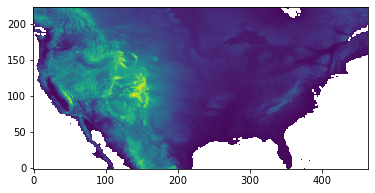

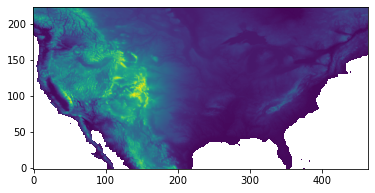

In [25]:
plt.imshow((NLDAS_elev[0,:,:]),origin='lower')
plt.show()

plt.imshow((NLDAS_elev_new[0,:,:]),origin='lower')
plt.show()

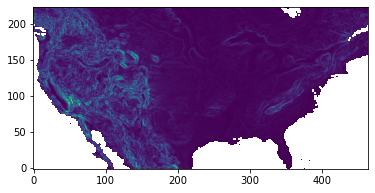

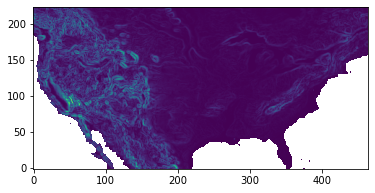

In [27]:
plt.imshow((NLDAS_slope[0,:,:]),origin='lower')
plt.show()

plt.imshow((NLDAS_slope_new[0,:,:]),origin='lower')
plt.show()

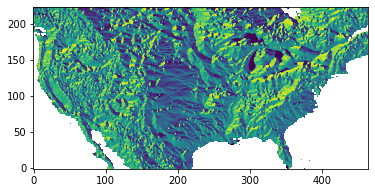

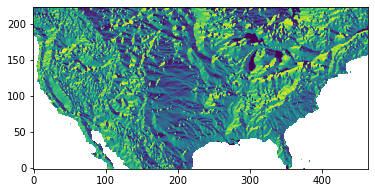

In [28]:
plt.imshow((NLDAS_aspect[0,:,:]),origin='lower')
plt.show()

plt.imshow((NLDAS_aspect_new[0,:,:]),origin='lower')
plt.show()

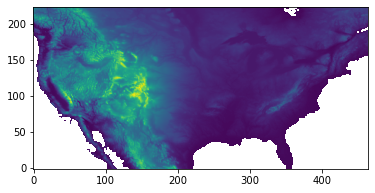

In [29]:
plt.imshow((STN_elev),origin='lower')
plt.show()